In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers, get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds, find_index_of_first_change
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_FW = True
LR = 1e-4
LOSS = "linearManhattan"
CHRYSOSTOM = False
SAMPLE = False
DYDIMUS = True
COMMENT = False
DEV_MINER = False
SPLIT = False

if SPLIT:
    SIZE = (32, 32, 32)
elif USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 64
else:
    SIZE = 64

seed = 42
IGNORE_KEYS = [
    "file", "author", "textgroup", "title", "tokens", "length", "modified_text"
]
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    return filename
    *x, y = filename.split(".")
    x = ".".join(x)
    *dirs, x = x.split("/")
    dirs = "/".join(dirs)
    print()
    name = f"Min[{DEV_MINER}]Split[{SPLIT}]Pos[{USE_POS}]FW[{USE_FW}]LR[{LR}]SIZE[{SIZE}]LOSS[{LOSS}]CHRYS[{CHRYSOSTOM}]DYD[{DYDIMUS}]SAMPLE[{SAMPLE}]COMMENT[{COMMENT}].{x}.{y}"
    if dirs:
        return f"{dirs}/{name}"
    return name
    

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
def get_train_dev_test(filtre, seed=42, ratio=10):
    test = len(filtre) * ratio // 100
    dev_and_test = test * 2
    print(f"Train categorical samples: {len(filtre)-dev_and_test}")
    print(f"Dev   categorical samples: {dev_and_test-test}")
    print(f"Test  categorical samples: {test}")
    r = random.Random(seed)
    r.shuffle(filtre)
    return filtre[:-dev_and_test], filtre[-dev_and_test:-test], filtre[-test:]


if NEW_DATASET:
    df = pd.read_csv("tlg-features.csv").sample(frac=1)
    #df = df[df.tokens >= 5000]
    #print(">= 5000", df.shape)
    #df = df[~df.file.isin(POETRY)]
    #print(">= Poetry", df.shape)
    # df = df[~df.title.str.contains("Dub\.|Sp\.|Fragm|Excerpt|(e cod\.)|Suda|recensio|fragm|sp\.|dub\.|(fort\. auctore)|Scholia")]
    print("Title filter", df.shape)
    #df = df[~df["full-pos-text"].isna()]
    #print(">= POS missing", df.shape)
    
    # Filter based on authors, to generalize better. Everything should be out of domain\
    train, dev, test = [], [], []
    if SPLIT_ON_AUTHORS:
        authors = df.author.value_counts()
        a, b, c = get_train_dev_test(authors[authors > 1].index.tolist())
    else:
        a, b, c = get_train_dev_test(df.title.unique().tolist())
        
    train.extend(a)
    dev.extend(b)
    test.extend(c)
    
#     a, b, c = get_train_dev_test(authors[authors == 1].index.tolist())
#     train.extend(a)
#     dev.extend(b)
#     test.extend(c)

    if SPLIT_ON_AUTHORS:
        train = df[df.author.isin(train)].copy(deep=True)
        dev = df[df.author.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.author.isin(test)].copy(deep=True)#.author.value_counts()
    else:
        train = df[df.title.isin(train)].copy(deep=True)
        dev = df[df.title.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.title.isin(test)].copy(deep=True)#.author.value_counts()
        
    train.to_csv("tlg-train.csv", index=False)
    dev.to_csv("tlg-dev.csv", index=False)
    test.to_csv("tlg-test.csv", index=False)
else:
    train = pd.read_csv("tlg-train.csv")
    dev = pd.read_csv("tlg-dev.csv")
    test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not DYDIMUS:
    train = train[~train.author.str.contains("Didym")]
    dev = dev[~dev.author.str.contains("Didym")]
    test = test[~test.author.str.contains("Didym")]
    
if not COMMENT:
    train = train[~train.title.str.contains("Comment")]
    dev = dev[~dev.title.str.contains("Comment")]
    test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1266, 1107)
Dev Shape : (157, 1107)
Test Shape : (158, 1107)


In [3]:
train.title.str.contains("Comment").value_counts()
test.title.str.contains("Comment").value_counts()

False    158
Name: title, dtype: int64

In [4]:
train.title.unique().shape

(383,)

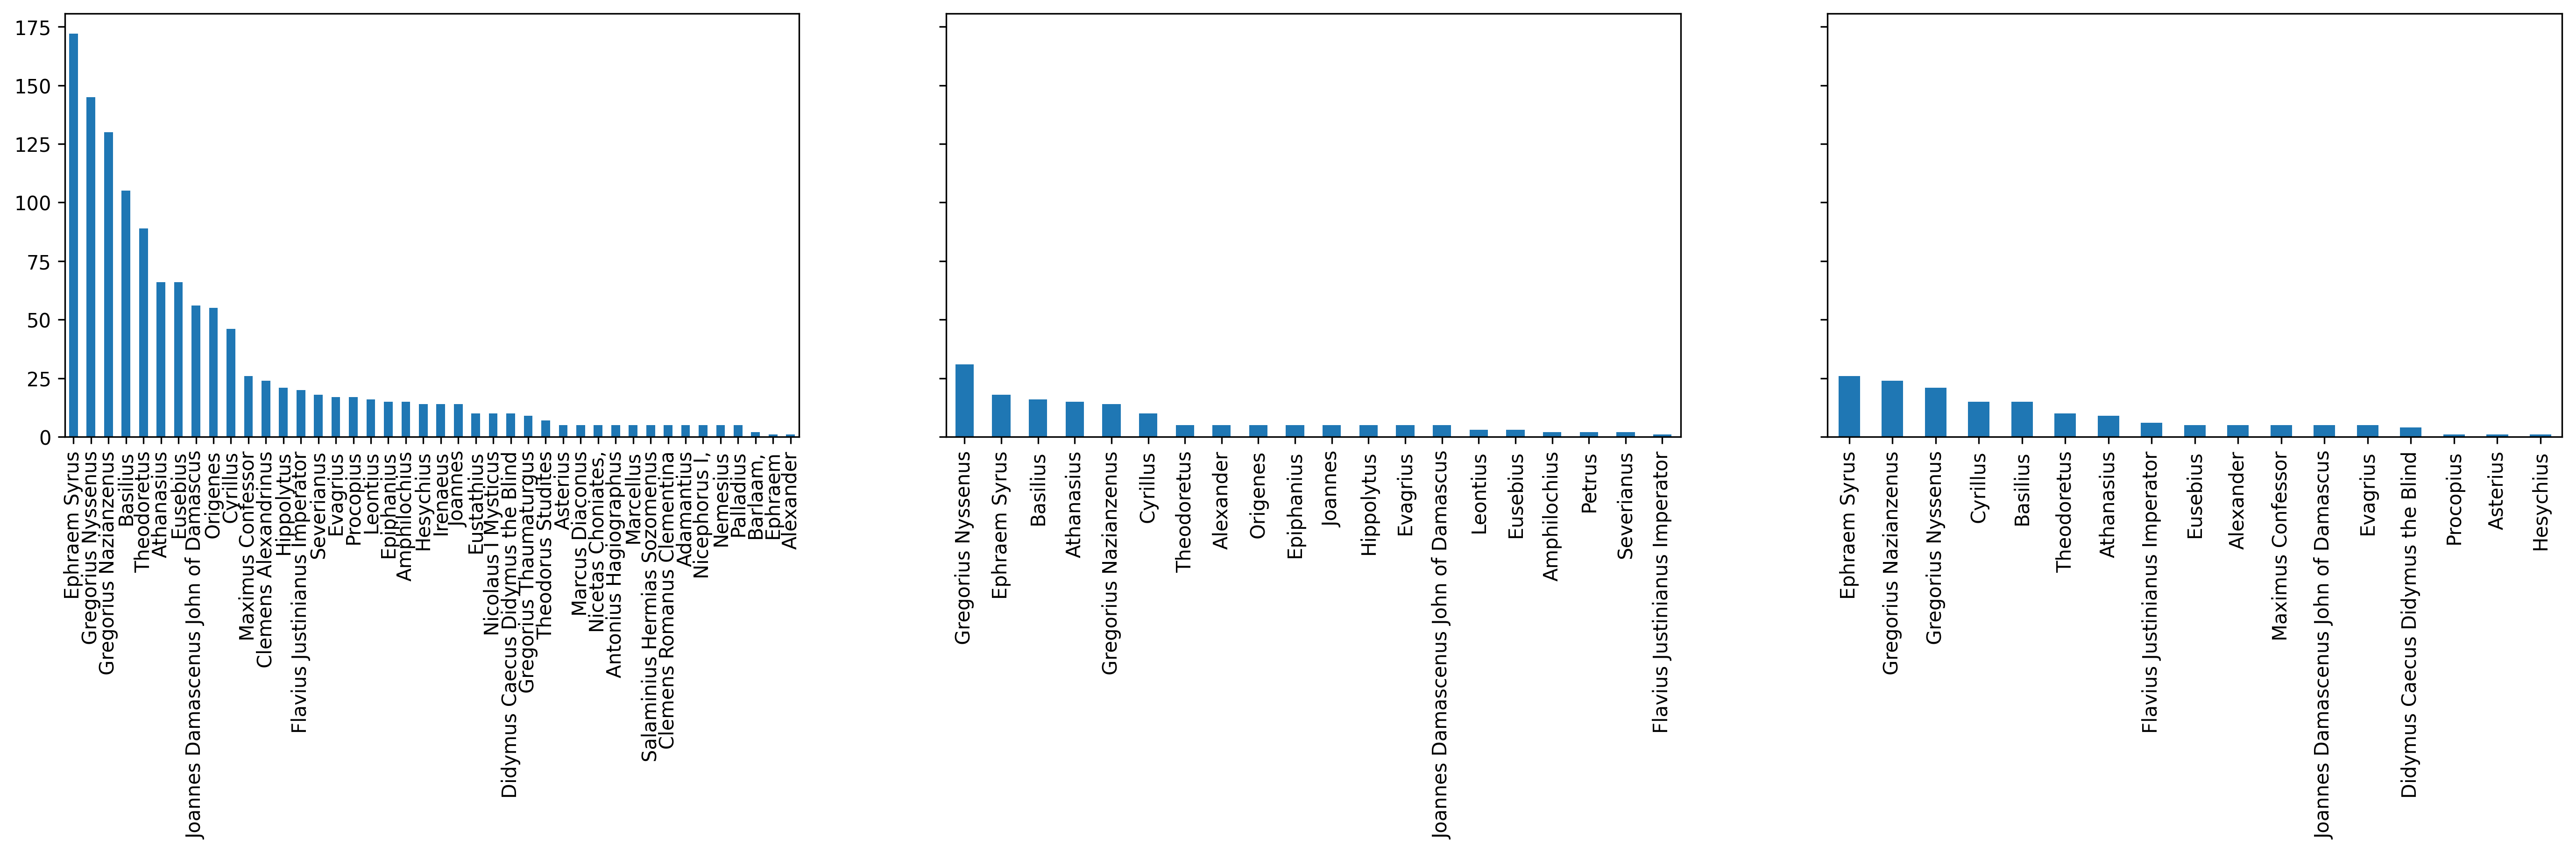

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
fig.savefig(make_file_name("samples.png"))

## Util functions

In [6]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col="Distance", noprint=False) -> None:
    if "distance" in col.lower():
        scores["Attribution"] = scores[col] <= distance
    else:
        scores["Attribution"] = scores[col] >= distance
    
    pos = scores[scores.IsAPair].Attribution.value_counts().to_dict()
    negs = scores[~scores.IsAPair].Attribution.value_counts().to_dict()
    
    tp = pos.get(True, 0)
    fn = pos.get(False, 0)
    fp = negs.get(True, 0)
    tn = negs.get(False, 0)
    if noprint is False:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Automatically retrieve some constant parameters

In [7]:
POS_COLS = [
    col
    for col in train.columns
    if col.startswith("$POS$")
]
FW_COLS = [
    col
    for col in train.columns
    if col.startswith("$MFW$")
]
IGNORE = set(IGNORE_KEYS + (
    POS_COLS if not USE_POS else []
) + (
    FW_COLS if not USE_FW else [])
)

## Get DataFrameWrapper

In [8]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data_test)
data._x_ignore

('length', 'file', 'tokens', 'title', 'author', 'modified_text', 'textgroup')

## CHecking some details

In [9]:
data.normalized.xs.head()

$POS$v-n-v  $POS$v-c-d  $POS$d-l-n  $POS$l-n-n  $POS$d-n-v  $POS$n-v-l  \
0    0.001786    0.010714    0.012500    0.017857    0.010714    0.017857   
3    0.002519    0.005038    0.015113    0.015113    0.002519    0.022670   
5    0.007018    0.001754    0.010526    0.021053    0.001754    0.024561   
6    0.000000    0.003992    0.007984    0.021956    0.000000    0.017964   
7    0.005894    0.015717    0.013752    0.011788    0.005894    0.009823   

   $POS$l-l-n  $POS$n-n-v  $POS$n-v-n  $POS$n-v-r  ...  $MFW$ἀμέλει  \
0    0.008929    0.008929    0.003571    0.014286  ...          0.0   
3    0.005038    0.002519    0.007557    0.000000  ...          0.0   
5    0.001754    0.012281    0.001754    0.010526  ...          0.0   
6    0.009980    0.013972    0.003992    0.011976  ...          0.0   
7    0.007859    0.011788    0.005894    0.011788  ...          0.0   

   $MFW$οὐδέ  $MFW$‹  $MFW$δηλαδὴ  $MFW$f  $MFW$ἐρρέθη  $MFW$σημείωσαι  \
0        0.0     0.0     0.000000     0.0          0.0             0.0   
3        0.0     0.0     0.000000     0.0          0.0             0.0   
5        0.0     0.0     0.000000     0.0          0.0             0.0   
6        0.0     0.0     0.001754     0.0          0.0             0.0   
7        0.0     0.0     0.000000     0.0          0.0             0.0   

   $MFW$a  $MFW$⌜  $MFW$⌝  
0     0.0     0.0     0.0  
3     0.0     0.0     0.0  
5     0.0     0.0     0.0  
6     0.0     0.0     0.0  
7     0.0     0.0     0.0  

[5 rows x 1100 columns]

## Training

In [10]:
from freestyl.supervised.siamese.features.model import SiameseFeatureModule

models = SiameseFeatureModule.load_from_checkpoint("lightning_logs/version_511/checkpoints/epoch=267-step=5360.ckpt") 

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [11]:
models.eval()

SiameseFeatureModule(
  (aucroc): AUROC()
  (distance): LpDistance()
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (_subloss): BCEWithLogitsLoss()
  (_linear_miner): BatchEasyHardMiner(
    (distance): LpDistance()
  )
  (miner): BatchEasyHardMiner(
    (distance): LpDistance()
  )
  (encoder): Sequential(
    (0): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=1100, out_features=64, bias=True)
  )
)

In [12]:
#pd.DataFrame({key:val for key, val in train_trainer.logger.history.items() if len(val) > 1})

### Get first FP distance

In [13]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.9994360596260179


In [14]:
scores[~scores.IsAPair].sort_values("Distance").head()

ComparedClass                                      ComparedLabel  \
744383  Gregorius Nyssenus  Gregorius Nyssenus - In sanctum pascha (vulgo ...   
459783            Asterius                           Asterius - Homiliae 1-14   
791210            Basilius  Basilius - Homilia dicta tempore famis et sicc...   
779491            Asterius                           Asterius - Homiliae 1-14   
695495            Asterius                           Asterius - Homiliae 1-14   

            ComparatorClass  \
744383             Asterius   
459783  Nicolaus I Mysticus   
791210             Asterius   
779491             Basilius   
695495             Basilius   

                                          ComparatorLabel  Distance  \
744383                           Asterius - Homiliae 1-14  3.360394   
459783             Nicolaus I Mysticus - Opuscula diversa  3.494215   
791210                           Asterius - Homiliae 1-14  3.499396   
779491  Basilius - Homilia dicta tempore famis et sicc...  3.518618   
695495  Basilius - Homilia dicta tempore famis et sicc...  3.554446   

        Probability  Attribution  IsAPair  K  
744383     0.135885        False    False  0  
459783     0.172413        False    False  0  
791210     0.199564        False    False  0  
779491     0.295996        False    False  0  
695495     0.375845        False    False  0

## Evaluating Dev for Test Threshold

In [15]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.8094878801524932


In [16]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Distance").head()

ComparedClass                                      ComparedLabel  \
3667          Severianus  Severianus - De tribus pueris (olim sub auctor...   
2402            Basilius                  Basilius - Homiliae in hexaemeron   
2704  Gregorius Nyssenus  Gregorius Nyssenus - In diem luminum (vulgo In...   
2393            Basilius                  Basilius - Homiliae in hexaemeron   
3657          Severianus  Severianus - De tribus pueris (olim sub auctor...   

         ComparatorClass                                    ComparatorLabel  \
3667  Gregorius Nyssenus    Gregorius Nyssenus - Encomium in xl martyres ii   
2402  Gregorius Nyssenus         Gregorius Nyssenus - Vita sanctae Macrinae   
2704            Basilius                       Basilius - De spiritu sancto   
2393  Gregorius Nyssenus  Gregorius Nyssenus - In diem luminum (vulgo In...   
3657  Gregorius Nyssenus            Gregorius Nyssenus - Contra fornicarios   

      Distance  Probability  Attribution  IsAPair  K  
3667  3.881654     0.795139         True    False  0  
2402  4.011965     0.265031        False    False  0  
2704  4.031127     0.590420         True    False  0  
2393  4.041293     0.267522        False    False  0  
3657  4.093093     0.817739         True    False  0

<AxesSubplot:>

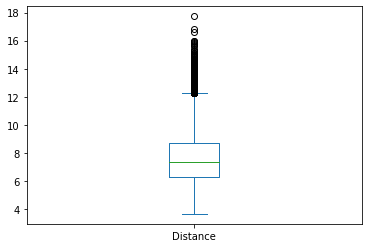

In [17]:
dev_pairs.Distance.plot.box()

In [18]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

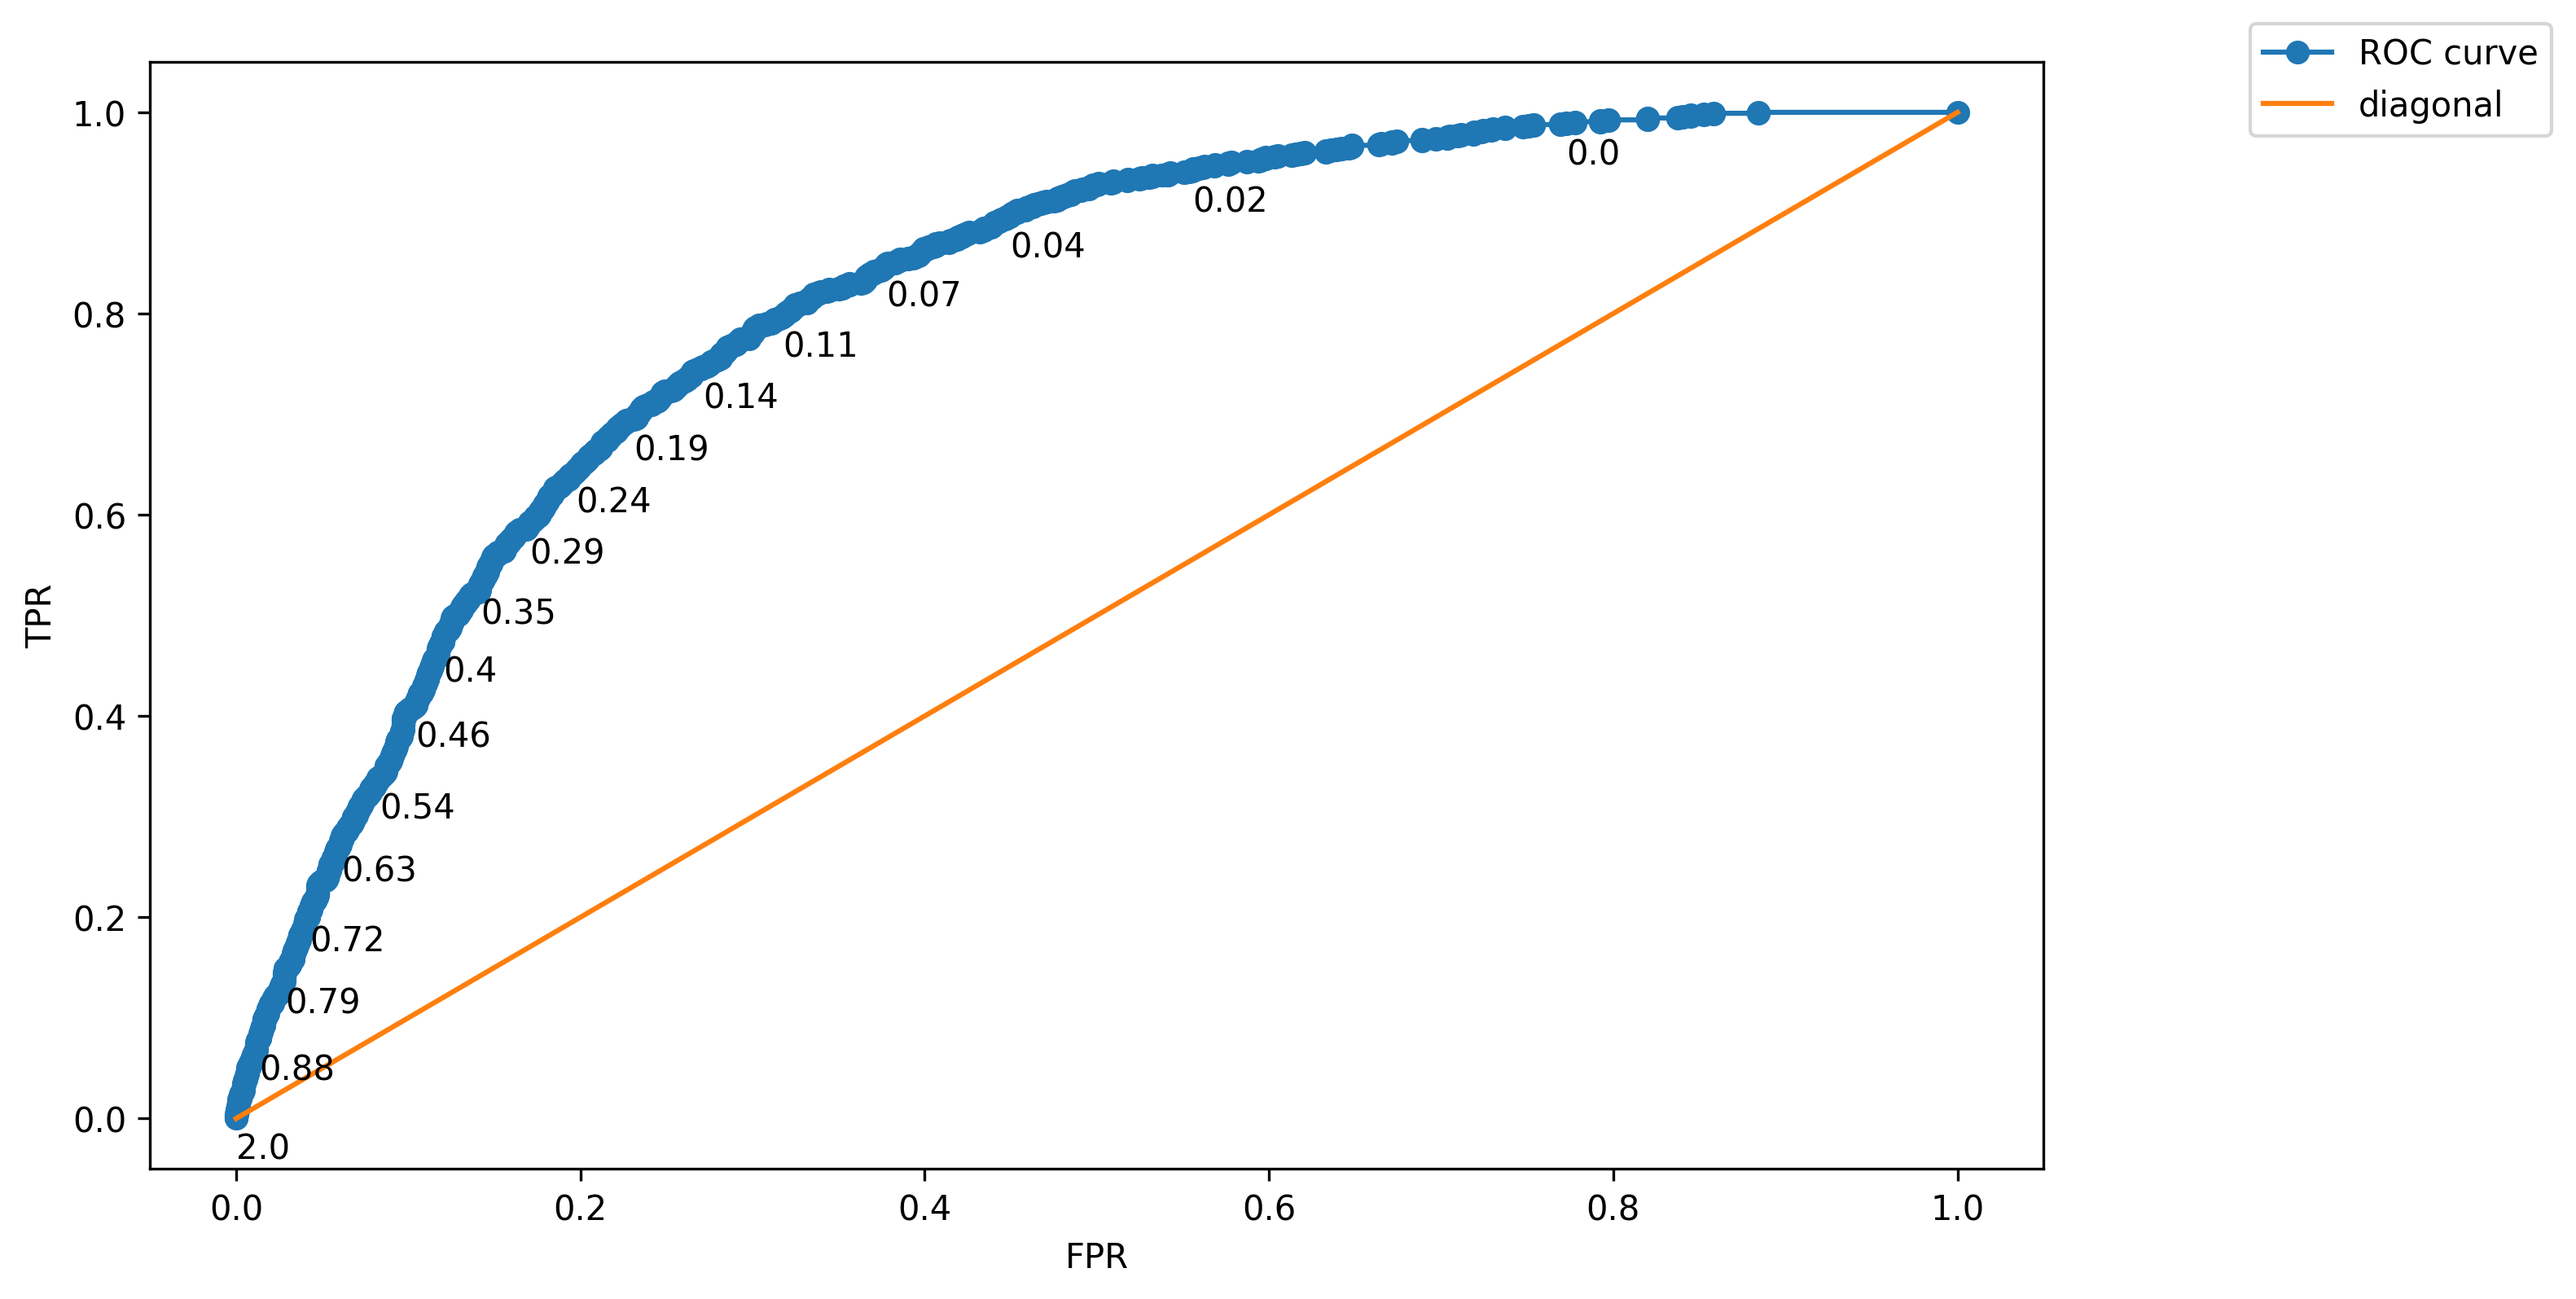

In [19]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs.Probability, nth=100, is_dist=False)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("aucroc-dev.png"))

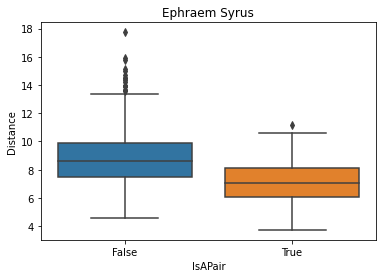

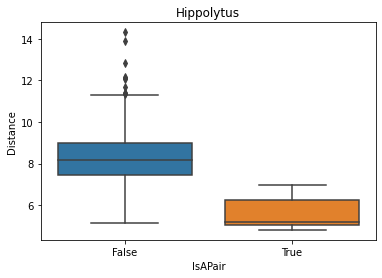

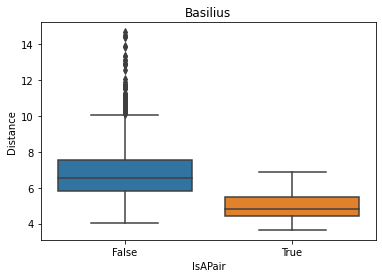

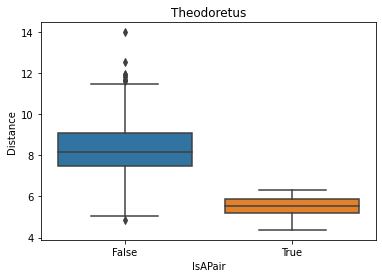

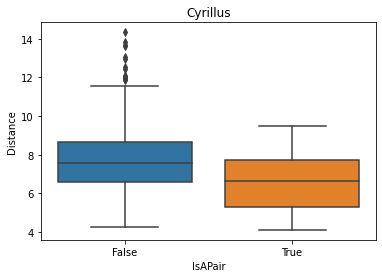

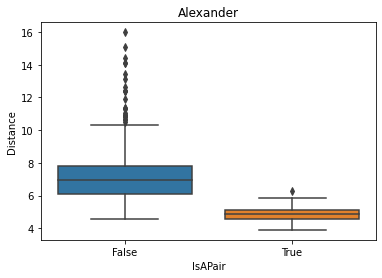

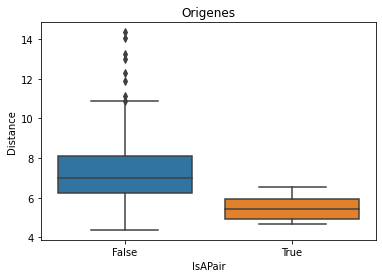

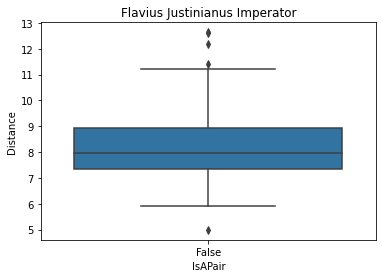

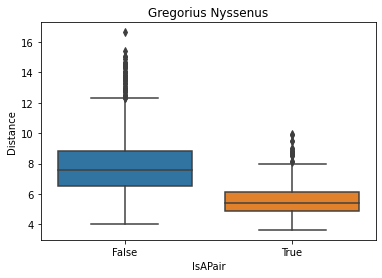

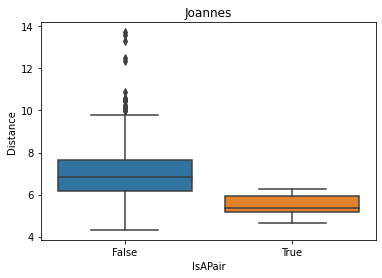

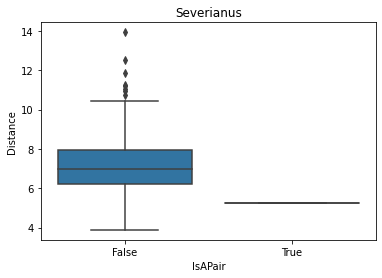

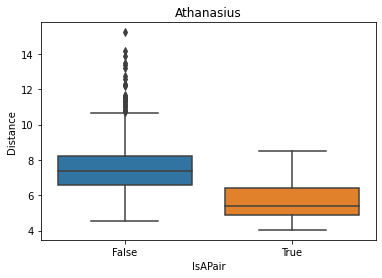

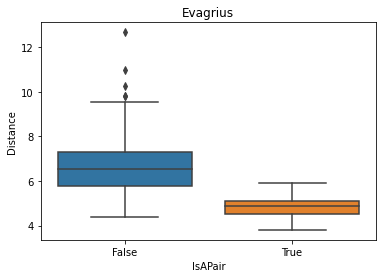

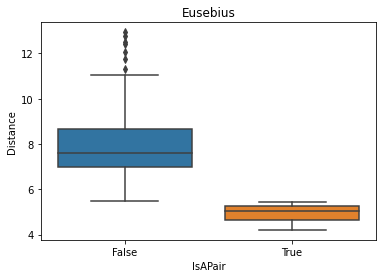

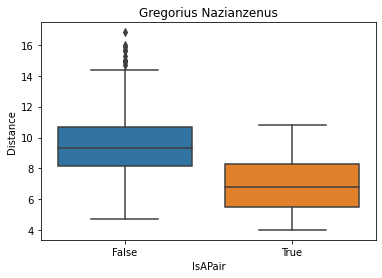

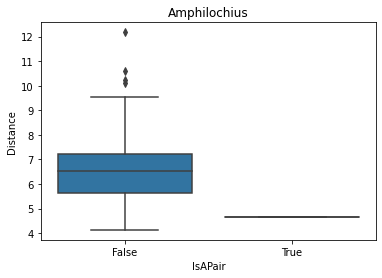

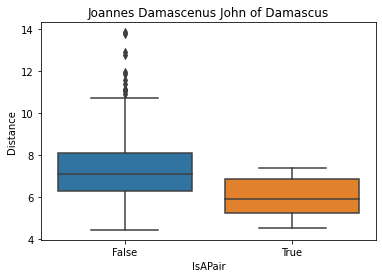

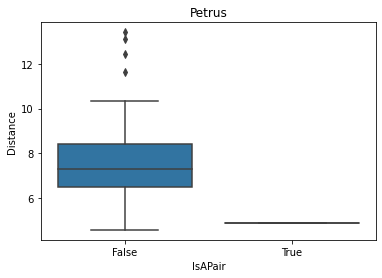

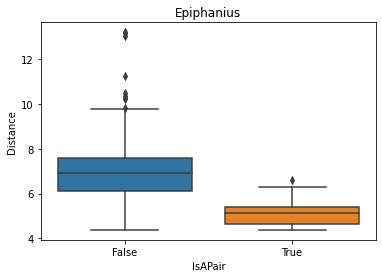

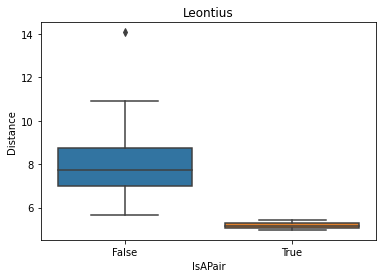

In [20]:
for cls in dev_pairs.ComparedClass.unique():
    plt.figure()
    sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y="Distance")
    plt.gca().set_title(cls)
    plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [21]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

True positives: 672
False Negative 396
True Negative 9561
False positives: 1617
Accuracy: 0.63

===
Without sampling
===

True positives: 472
False Negative 358
True Negative 9561
False positives: 1617
Accuracy: 0.57


/tmp/ipykernel_8092/3133452024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(472, 1617, 9561, 358)

## Evaluating Test with Dev Threshold

In [22]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [23]:
test_pairs[~test_pairs.IsAPair].sort_values("Distance").head()

ComparedClass  \
9646               Basilius   
9323  Gregorius Nazianzenus   
9497               Basilius   
2057     Gregorius Nyssenus   
9325  Gregorius Nazianzenus   

                                          ComparedLabel  \
9646            Basilius - De legendis gentilium libris   
9323  Gregorius Nazianzenus - Funebris oratio in pat...   
9497            Basilius - De legendis gentilium libris   
2057    Gregorius Nyssenus - In inscriptiones Psalmorum   
9325  Gregorius Nazianzenus - Funebris oratio in pat...   

                    ComparatorClass  \
9646          Gregorius Nazianzenus   
9323                       Basilius   
9497          Gregorius Nazianzenus   
2057  Flavius Justinianus Imperator   
9325                       Basilius   

                                        ComparatorLabel  Distance  \
9646  Gregorius Nazianzenus - Funebris in laudem Cae...  3.964608   
9323            Basilius - De legendis gentilium libris  3.979522   
9497  Gregorius Nazianzenus - Funebris in laudem Cae...  4.079055   
2057  Flavius Justinianus Imperator - Contra monophy...  4.204568   
9325            Basilius - De legendis gentilium libris  4.249874   

      Probability  Attribution  IsAPair  K  
9646     0.763393        False    False  0  
9323     0.605745        False    False  0  
9497     0.664136        False    False  0  
2057     0.516130        False    False  0  
9325     0.523298        False    False  0

In [24]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

ROC: 0.9042257562748666
True positives: 703
False Negative 470
True Negative 10313
False positives: 917
Accuracy: 0.60

===
Without sampling
===

True positives: 469
False Negative 439
True Negative 10313
False positives: 917
Accuracy: 0.52


/tmp/ipykernel_8092/3133452024.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(469, 917, 10313, 439)

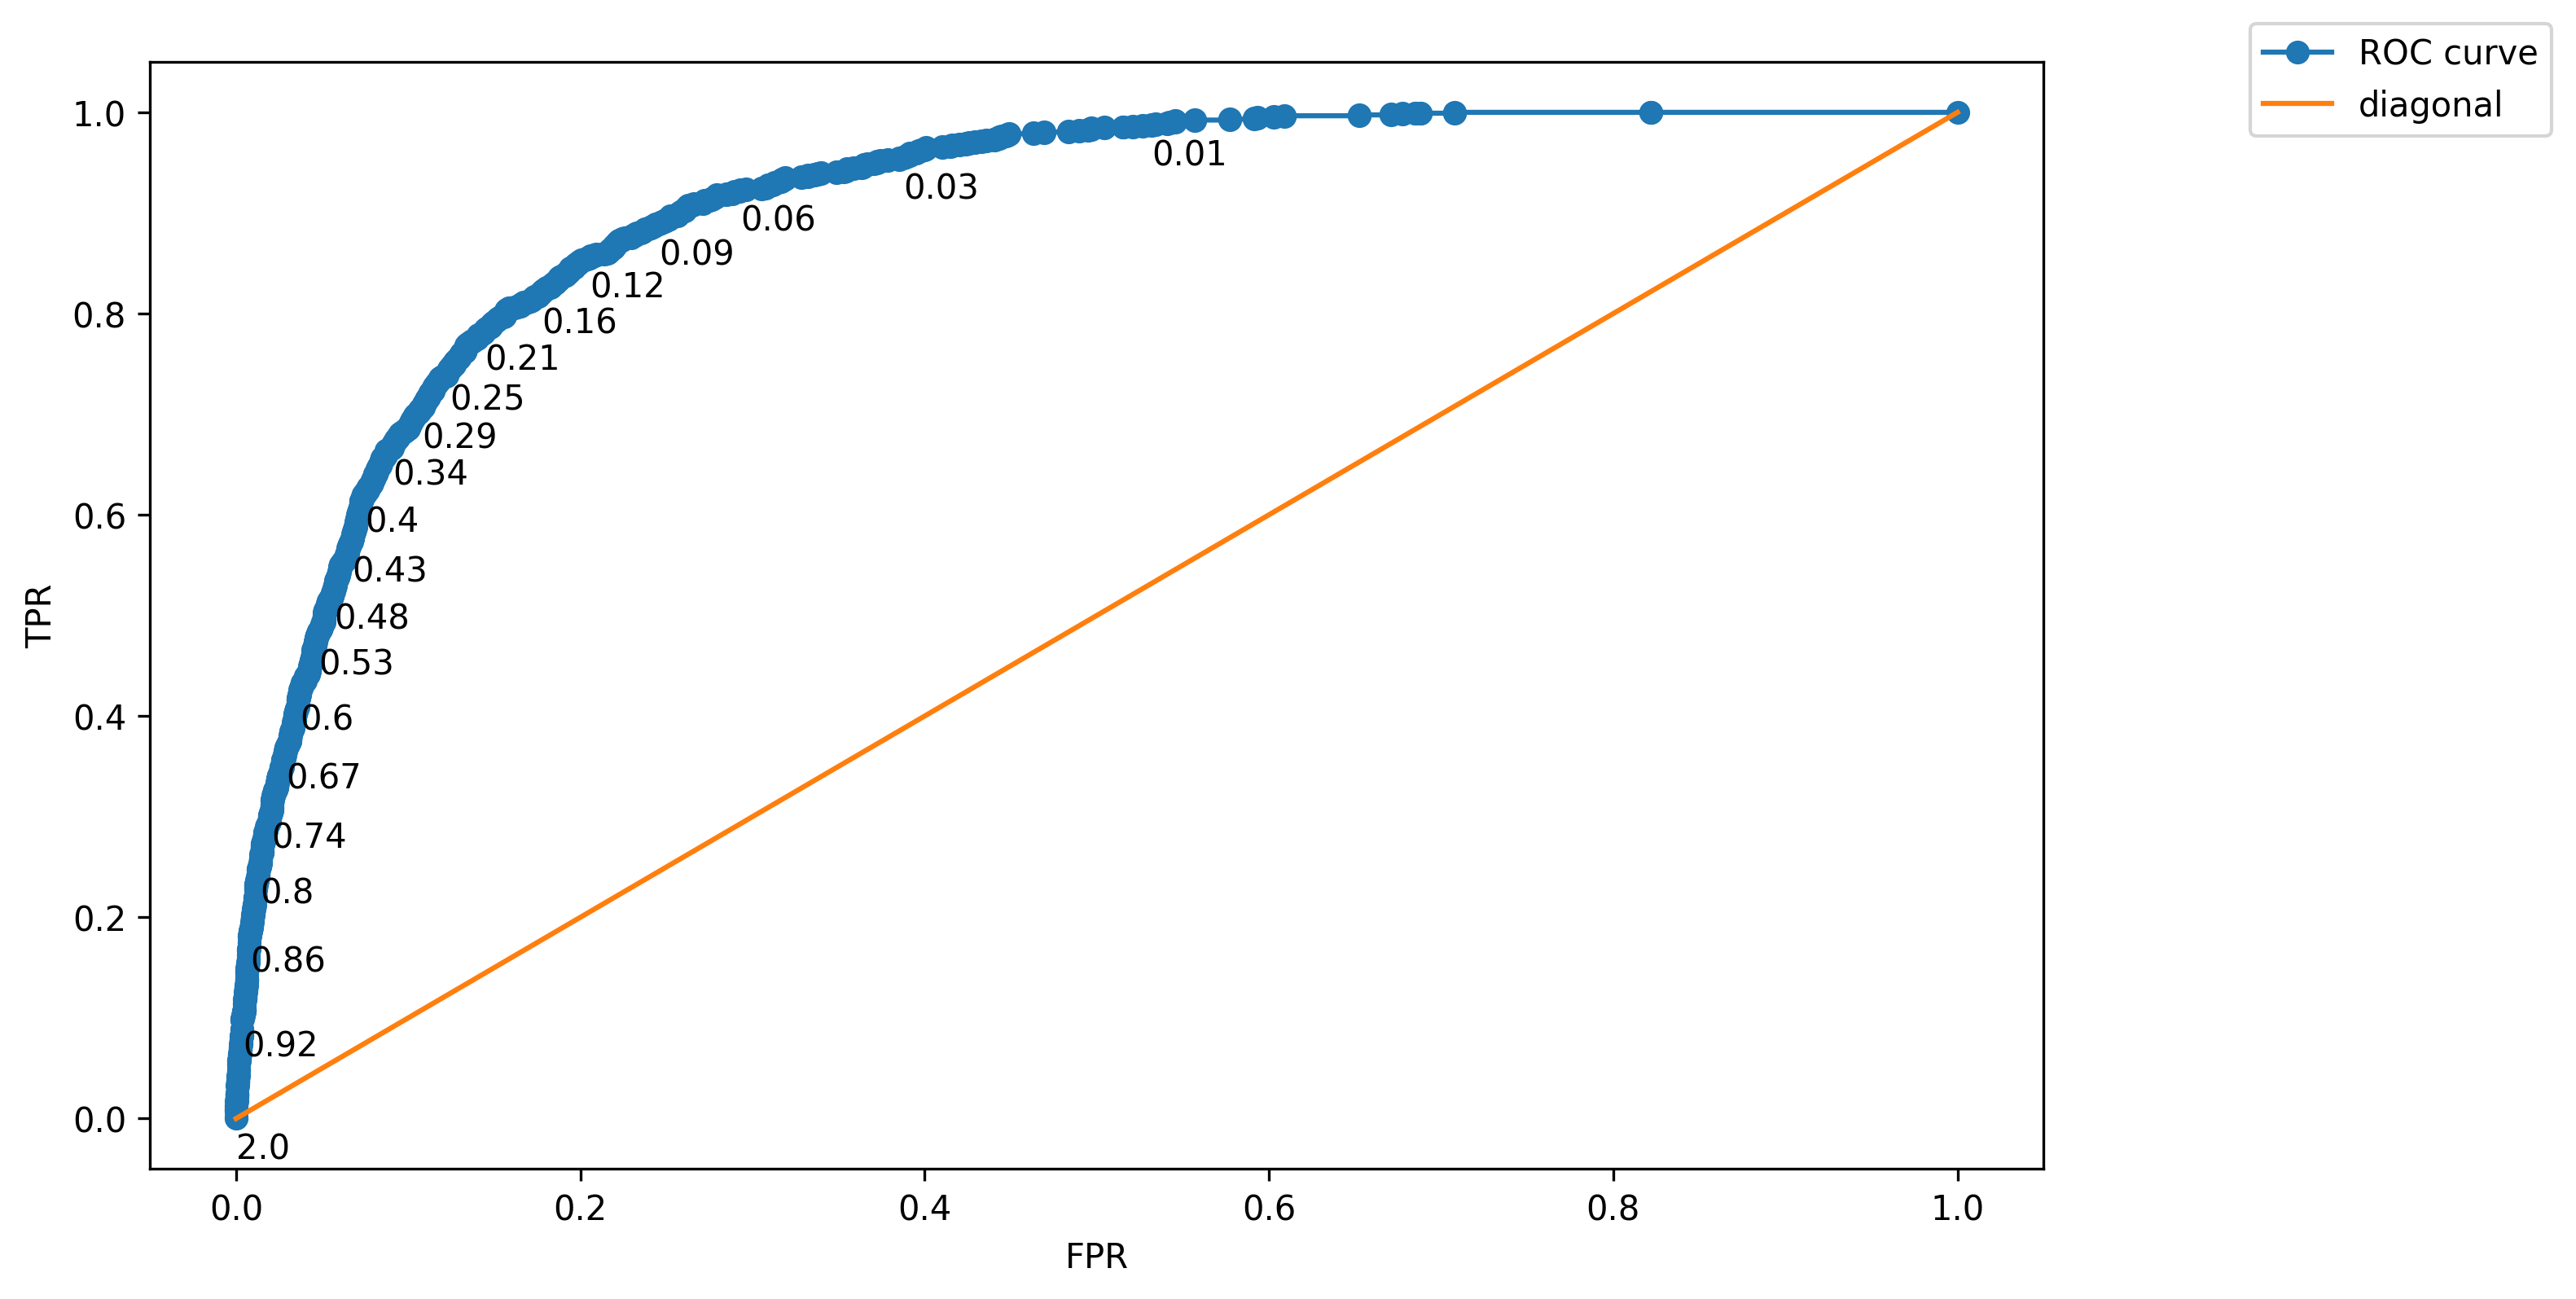

In [25]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs.Probability, nth=75, is_dist=False)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [26]:
dev_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [27]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=IGNORE.union({'$MFW$μηδ', '$MFW$εὖ', '$MFW$ἐς', '$MFW$ταὐτὸν', '$MFW$ἧττον', '$MFW$μάλα', '$MFW$οὔτ', '$MFW$τ', '$MFW$γ', '$MFW$ἤτοι', '$MFW$ἥ', '$MFW$εἴπερ', '$MFW$η', '$MFW$κ', '$MFW$α', '$MFW$β', '$MFW$αʹ', '$MFW$[', '$MFW$p', '$MFW$̣', '$MFW$𐅻'}))
#
print(len(DFW.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

1038
1100 new features found, setting them as 0.
1100
1100


In [28]:
models.eval()
pairs = get_df_prediction(trainer, model=models, compared=DFW, threshold=.5)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [29]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.sort_values(["Probability"]).tail()

ComparedClass                                      ComparedLabel  \
2140           PC7                               PC7 - DeIeiunoSermo2   
2923           PC7                               PC7 - DeIeiunoSermo3   
4786          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
5000         PC20b                     PC20b - DeRemissionePeccatorum   
4967         PC20b                     PC20b - DeRemissionePeccatorum   

     ComparatorClass                                    ComparatorLabel  \
2140             PC6                         PC6 - DePoenintentiaSermo2   
2923             PC6                         PC6 - DePoenintentiaSermo2   
4786             PC6                         PC6 - DePoenintentiaSermo2   
5000             PC6                         PC6 - DePoenintentiaSermo2   
4967           PC20b  PC20b - InDrachmamEttInIlludHomoQuidamHabebatD...   

      Distance  Probability  Attribution  IsAPair  K  
2140  7.906548     0.997101         True    False  0  
2923  8.774742     0.997438         True    False  0  
4786  8.296954     0.997565         True    False  0  
5000  8.852365     0.997937         True    False  0  
4967  6.726017     0.998117         True     True  0

In [30]:
pairs["RoundedProbability"] = pairs.Probability.round(3)
dists = sorted(pairs["RoundedProbability"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1


for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col="Probability", noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs.RoundedProbability == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col="Probability", noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs.RoundedProbability == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    print(dist)
    

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

In [47]:
pairs[(pairs.TestPre >= .90)].sort_values(["TestPre"])#[
#    (col for col in pairs.columns if col.startswith("Test"))
#]

ComparedClass                                      ComparedLabel  \
3161           PC7                               PC7 - DeIeiunoSermo3   
4735          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
4778          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
4902           PC1                           PC1 - InGenesimSermones1   
604            PC6                         PC6 - DePoenintentiaSermo1   
4956         PC20b                     PC20b - DeRemissionePeccatorum   
4980         PC20b                     PC20b - DeRemissionePeccatorum   
2089           PC7                               PC7 - DeIeiunoSermo2   
3193          PC17               PC17 - InIlludAttendideNeEleemosynam   
3115           PC7                               PC7 - DeIeiunoSermo3   
4984         PC20b                     PC20b - DeRemissionePeccatorum   
3829          PC16                         PC16 - InPsalmum50Homilia1   
4412          PC13             PC13 - ContraIudaeosGentilesHaereticos   
2180           PC7                               PC7 - DeIeiunoSermo2   
6276           PC7                               PC7 - DeIeiunoSermo5   
1861           PC7                               PC7 - DeIeiunoSermo7   
650            PC6                         PC6 - DePoenintentiaSermo1   
5331           PC8                            PC8 - DePatientiaSermo2   
4781          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
4786          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
4967         PC20b                     PC20b - DeRemissionePeccatorum   
6111          PC18                   PC18 - InParabolamDeFilioProdigo   
6026           PC6                         PC6 - DePoenintentiaSermo3   
4991         PC20b                     PC20b - DeRemissionePeccatorum   
5000         PC20b                     PC20b - DeRemissionePeccatorum   
5765         PC20b  PC20b - InDrachmamEttInIlludHomoQuidamHabebatD...   
5760         PC20b  PC20b - InDrachmamEttInIlludHomoQuidamHabebatD...   
5696           PC7                               PC7 - DeIeiunoSermo6   
5423          PC16                PC16 - InIlludSufficitTibiGratiaMea   
5051          PC16                         PC16 - InPsalmum50Homilia2   
221           PC13                         PC13 - InVenerabilemCrucem   
4725          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
440            PC6                         PC6 - DePoenintentiaSermo1   
1470           PC8                            PC8 - DePatientiaSermo1   
1568           PC8                            PC8 - DePatientiaSermo1   
2135           PC7                               PC7 - DeIeiunoSermo2   
2140           PC7                               PC7 - DeIeiunoSermo2   
2226           PC7                               PC7 - DeIeiunoSermo2   
2447          PC10                               PC10 - DePrecatione2   
4730          PC18  PC18 - InIlludSimileEstRegnumCaelorumPatriFami...   
2918           PC7                               PC7 - DeIeiunoSermo3   
3911          PC16                         PC16 - InPsalmum50Homilia1   
4048          PC16                         PC16 - InPsalmum50Homilia1   
4241           PC7                               PC7 - DeIeiunoSermo4   
4246           PC7                               PC7 - DeIeiunoSermo4   
4368           PC5                             PC5 - InSanctaVirginem   
6281           PC7                               PC7 - DeIeiunoSermo5   
4615           PC2                                    PC2 - DeSusanna   
2923           PC7                               PC7 - DeIeiunoSermo3   
6285         PC20b  PC20b - InIlludSimileEstRegnumCaelorumGranoSin...   

     ComparatorClass                                    ComparatorLabel  \
3161             PC4                            PC4 - InPaschaSermones6   
4735           PC20b                     PC20b - DeRemissionePeccatorum   
4778           PC20b  PC20b - InIlludSimileEstRegnumCael

In [32]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))

## Visualize

In [33]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)

# We first get the wonderful classes of compared
dev_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_dev, model=models, batch_size=8))
)
dev_vectors = torch.cat([vec.cpu() for vec in dev_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_dev.get_labels(), data_dev.ys.tolist(), dev_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [34]:
# We first get the wonderful classes of compared
test_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_test, model=models, batch_size=8))
)
test_vectors = torch.cat([vec.cpu() for vec in test_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_test.get_labels(), data_test.ys.tolist(), test_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [35]:
# We first get the wonderful classes of compared
pcs, _ = zip(
    *trainer.predict(models, make_dataloader(DFW, model=models, batch_size=8))
)
pcs = torch.cat([vec.cpu() for vec in pcs], dim=0)


for label, vector in zip(DFW.get_labels(), pcs.tolist()):
    author, label = label.split(" - ")
    dataframe.append((author, label, *vector))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [36]:
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df

Author                                              Title  \
0       Gregorius Nyssenus             De professione Christiana ad Harmonium   
1            Ephraem Syrus  Sermo adversus haereticos, in quo tum ex marga...   
2            Ephraem Syrus  Sermo adversus haereticos, in quo tum ex marga...   
3    Gregorius Nazianzenus  Funebris in laudem Caesarii fratris oratio (or...   
4                 Cyrillus  Epistulae paschales sive Homiliae paschales (e...   
..                     ...                                                ...   
266                    PC4                                  InPaschaSermones6   
267                    PC4                                  InPaschaSermones6   
268                    PC6                               DePoenintentiaSermo2   
269                    PC6                               DePoenintentiaSermo2   
270                    PC6                               DePoenintentiaSermo2   

         Dim0      Dim1      Dim2      Dim3      Dim4      Dim5      Dim6  \
0    0.413864 -0.086979  1.378549 -1.081878  1.262409  1.750765 -1.257509   
1   -0.280505 -0.402864  0.285646  0.265192 -0.331370  0.760932  0.690218   
2    0.789922 -0.064054  1.070006 -1.574437 -0.462557  0.536331  0.705626   
3   -1.303828  0.792479 -1.287881  0.472763 -0.478138  1.738086  0.600078   
4   -0.195385  0.160762 -1.490358  0.808918  0.651901 -0.290246 -1.702056   
..        ...       ...       ...       ...       ...       ...       ...   
266  1.078023  0.127531 -0.898879 -0.542883 -0.697777 -0.045920  1.036568   
267  0.044658  0.032322 -0.807803 -1.326994  0.257014 -0.842444  0.841767   
268 -2.094753  0.730691 -2.021512 -0.104719 -0.397258 -0.686837  1.968675   
269 -2.045140  1.194003 -1.219201  0.185732  0.837618  0.020258  1.483805   
270 -0.550590 -0.803668 -0.832882 -0.179142 -1.732439  0.664677  2.058881   

         Dim7  ...     Dim54     Dim55     Dim56     Dim57     Dim58  \
0   -0.365121  ... -0.009992  0.715106 -0.737079  1.218863 -0.531734   
1   -0.583432  ...  0.427928 -1.393277  1.000353 -0.076694 -0.680307   
2   -0.689790  ...  0.223703 -1.805631 -0.088327 -0.050682  0.127815   
3    0.278930  ...  0.279467  0.647571 -0.663909 -0.948049 -0.167769   
4    1.215653  ... -0.687461  0.168670  0.172897  0.553844  0.139700   
..        ...  ...       ...       ...       ...       ...       ...   
266 -0.083075  ... -0.445182 -0.293640 -0.640824  0.180855  0.293207   
267  0.050230  ...  0.275925 -0.177398  0.357199  0.746652  0.432500   
268 -1.310115  ...  0.326209  0.537396  0.793044 -2.098827 -0.537745   
269  1.360721  ...  0.987815  0.725016  0.827038 -1.487245  0.637931   
270 -0.472735  ...  0.820679 -0.119217  1.997016 -2.741455 -0.588359   

        Dim59     Dim60     Dim61     Dim62     Dim63  
0   -0.192699  0.855683 -0.377446  0.470384  0.684201  
1    0.093723  1.163786 -0.096119  0.421069 -0.232573  
2    0.965040  0.726174 -0.631727  0.592588  0.311898  
3    0.080841 -0.205742 -0.802639  0.580412 -0.900750  
4   -0.411582 -0.609217  0.760663 -0.341207  1.270301  
..        ...       ...       ...       ...       ...  
266 -0.105191  0.721933  0.136374  0.266763  0.686753  
267  0.044179  0.752279  0.441375 -0.526354  0.885028  
268  0.579836  0.517214 -1.172143  0.654914 -1.462279  
269 -0.367361  0.965001 -0.911635 -0.783230 -1.126373  
270 -0.983909 -0.376640 -0.427495  0.170682 -0.512410  

[271 rows x 66 columns]

In [37]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("plotly.html"))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/uma

In [38]:
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df = df[df.Author.str.contains("PC")]
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("pc-plotly.html"))